In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

### Import dataset and put into dataloader

In [7]:
# import CIFAR-10 dataset into trainset, testset
# load in to trainloader, testloader

# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_color)
trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=4,
                                          shuffle=True, num_workers=2)

testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=4,
                                         shuffle=False, num_workers=2)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


### Pre-processing: Convert all rgb images to gray images

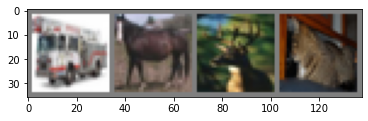

torch.Size([4, 3, 32, 32])


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_color))

# show dataiter shape
print(images_color.shape)

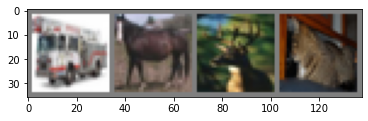

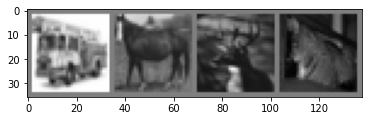

images_gray shape:  torch.Size([4, 1, 32, 32])


In [9]:
# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
images_gray = images_gray.reshape(4,1,32,32)

imshow(torchvision.utils.make_grid(images_color))
imshow(torchvision.utils.make_grid(images_gray))
print("images_gray shape: ", images_gray.shape)

### Define the MLP network

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 32x32x3
        super(MLP_net, self).__init__()
        
        self.layer1 = nn.Linear(1024,1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.layer2 = nn.Linear(1024,3072)
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.layer2(x)
        
        return x

mlp_net = MLP_net().to(device)

print("is cude: ", next(mlp_net.parameters()).is_cuda)

if os.path.exists("./saved_model/mlp.pt"):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load("./saved_model/mlp.pt"))

is cude:  True
Continue training from the saved model


### Define the loss function and optimizer

In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard to save all training output logs

In [14]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs_mlp/")

### Train the network

In [8]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data_color in enumerate(trainloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, labels_color = data_color
        images_gray = rgb2gray_batch(images_color)
        
        # put data in gpu/cpu
        images_color = images_color.to(device)
        images_gray = images_gray.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # input: images_gray
        images_gray = images_gray.view(4,-1)
        outputs = mlp_net(images_gray)
        # change the shape of images_color: [4,3,32,32] -> [4,3072]
        images_color = images_color.reshape(images_color.shape[0], -1) 
        loss = criterion(outputs, images_color)
        loss.backward()
        optimizer.step()

        # print output statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            writer.add_scalar('Loss/train', running_loss/2000, len(trainset_color)*epoch + i)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.106
[1,  4000] loss: 0.105
[1,  6000] loss: 0.106
[1,  8000] loss: 0.105
[1, 10000] loss: 0.105
[1, 12000] loss: 0.106
[2,  2000] loss: 0.105
[2,  4000] loss: 0.106
[2,  6000] loss: 0.106
[2,  8000] loss: 0.105
[2, 10000] loss: 0.105
[2, 12000] loss: 0.105
[3,  2000] loss: 0.106
[3,  4000] loss: 0.106
[3,  6000] loss: 0.106
[3,  8000] loss: 0.105
[3, 10000] loss: 0.106
[3, 12000] loss: 0.106
[4,  2000] loss: 0.105
[4,  4000] loss: 0.106
[4,  6000] loss: 0.106
[4,  8000] loss: 0.105
[4, 10000] loss: 0.105
[4, 12000] loss: 0.105
[5,  2000] loss: 0.105
[5,  4000] loss: 0.105
[5,  6000] loss: 0.106
[5,  8000] loss: 0.104
[5, 10000] loss: 0.105
[5, 12000] loss: 0.105
[6,  2000] loss: 0.104
[6,  4000] loss: 0.105
[6,  6000] loss: 0.106
[6,  8000] loss: 0.105
[6, 10000] loss: 0.103
[6, 12000] loss: 0.104
[7,  2000] loss: 0.105
[7,  4000] loss: 0.105
[7,  6000] loss: 0.104
[7,  8000] loss: 0.105
[7, 10000] loss: 0.105
[7, 12000] loss: 0.104
[8,  2000] loss: 0.106
[8,  4000] 

### Inference on train dataset

images_color:  torch.Size([4, 3, 32, 32])


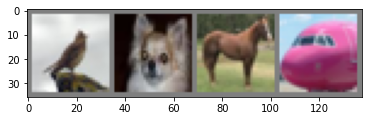

images_gray:  torch.Size([4, 32, 32])


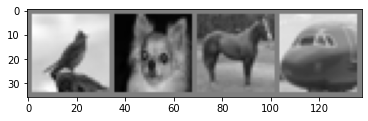

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3072])
torch.Size([4, 3, 32, 32])


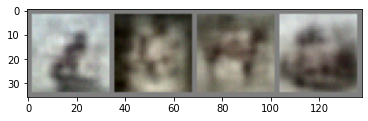

In [15]:
# get some random training images
dataiter = iter(trainloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(4,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(4,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [4,3072]
images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print(outputs.shape)

images_color = outputs.reshape(4,3,32,32)
print(images_color.shape)

images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))


### Save the model

In [16]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
    
torch.save(mlp_net.state_dict(), './saved_model/mlp.pt')

### Inference on test dataset

images_color:  torch.Size([4, 3, 32, 32])


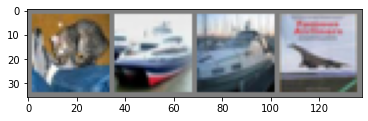

images_gray:  torch.Size([4, 32, 32])


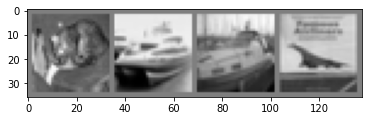

torch.Size([4, 3072])
torch.Size([4, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


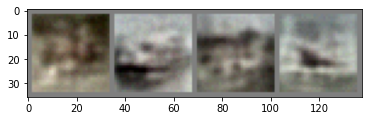

In [17]:
# get some random training images
dataiter = iter(testloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(4,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(4,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [4,3072]
images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print(outputs.shape)

images_color = outputs.reshape(4,3,32,32)
print(images_color.shape)

images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))
